# Natural Gas Price Data Estimation

#### Summary
- Initially I started with understanding the dataset and all related parameters inside.
- Multiple visualizations from different perspectives helped discovering patterns(12 months(lag=12) high auto-correlation found).
- A mathematical proof to visual patterns found was undertaken.
- Utilized ARIMA model to forecast next 12 months data points.
- Utlized interpolation function combined with extrapolation to estimate prices of any date.

In [260]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.interpolate import interp1d

#reading the file and defining it into a dataframe for analysis
df = pd.read_csv("Nat_Gas.csv")


In [261]:
df.head(5)

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [262]:
df.shape

(48, 2)

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


In [264]:
# Converting 'Dates' to datetime format and setting it as index
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


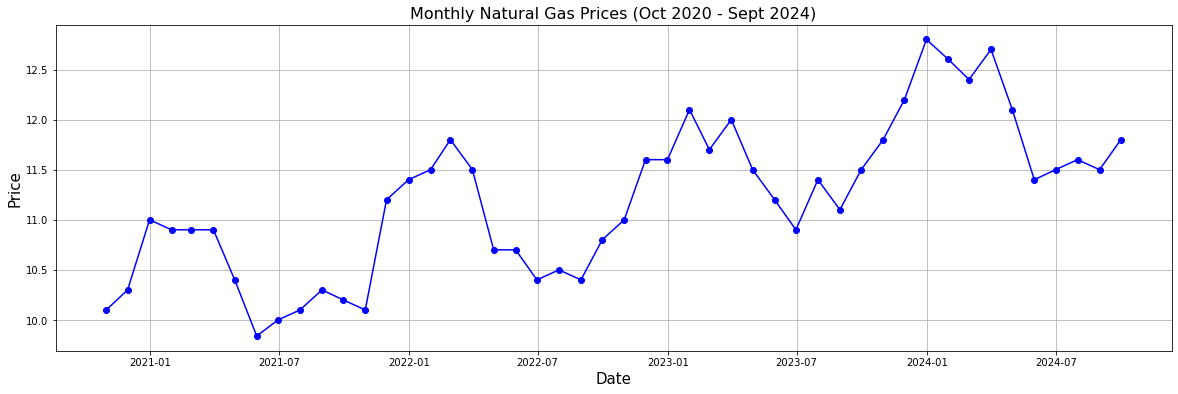

In [266]:
# Plotting the raw data
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Prices'], marker='o', color='b', linestyle='-')
plt.title('Monthly Natural Gas Prices (Oct 2020 - Sept 2024)', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.grid(True)
plt.show()

-  We observe that the prices are steadily rising every year with a regular peak around the start of the year and a dip in around months April-August followed by a rise between August-January for all the years.

### Visualizing the dataset further to identify patterns

#### Decomposing the time series to observe trends, seasonality and residuals for monthly data.

- I have made use of seasonal_decompose function which disaggregates a time series into three components -- trend, seasonal and residual. 
- Trend component captures the overall levels of the time series.
- Seasonal component captures patterns that repeat every season.
- Residual is what is left as remainder in the series after removing the above two components.


Text(0, 0.5, 'Average Price)')

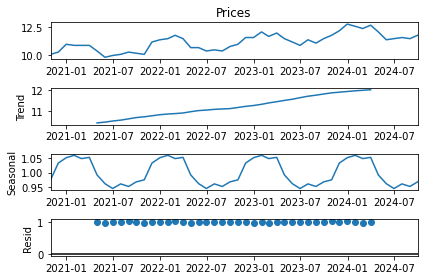

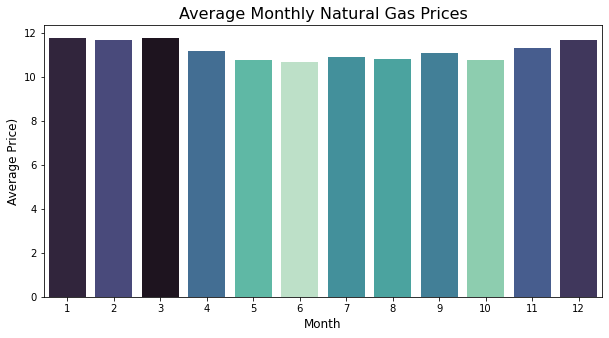

In [267]:
# Decomposing the time series to observe trends, seasonality, and residuals
result = seasonal_decompose(df['Prices'], model='multiplicative', period=12)
result.plot()


# Gathering monthly trend for gaining insights for seasonality based on monthly data.
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['Prices'].mean()

plt.figure(figsize=(10, 5))

# sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='mako')
pal=sns.color_palette("mako", len(monthly_avg))
rank = monthly_avg.argsort().argsort()
# plotting while using mako as color palette and reversing the palette based on rank so that higher price yields darker color.
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette=np.array(pal[::-1])[rank])


plt.title('Average Monthly Natural Gas Prices', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Price)', fontsize=12)
# plt.show()


- We observe a similar pattern of peaks at the start and end of the year and steady decline between April-August and incline between August-January in prices.

#### Decomposing the time series to observe trends, seasonality and residuals for quarterly data.

Text(0, 0.5, 'Average Price')

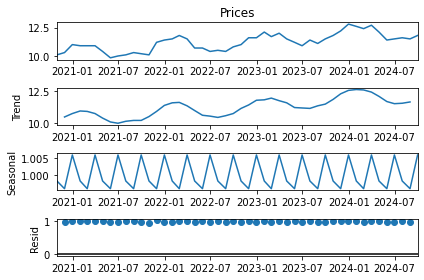

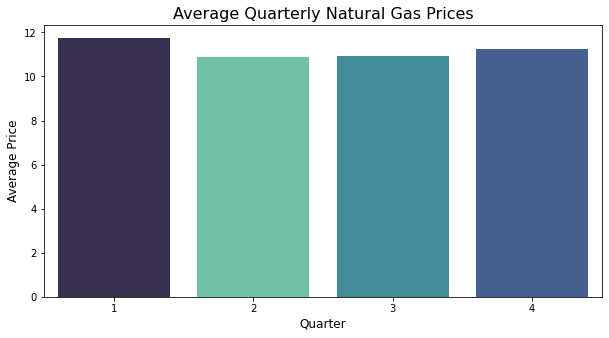

In [268]:
# Decomposing the time series to observe trends, seasonality, and residuals
result = seasonal_decompose(df['Prices'], model='multiplicative', period=3)
result.plot()


# Gathering monthly trend for gaining insights for seasonality based on monthly data.
df['Quarter'] = df.index.quarter
quarterly_avg = df.groupby('Quarter')['Prices'].mean()

plt.figure(figsize=(10, 5))

# sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='mako')
pal=sns.color_palette("mako", len(quarterly_avg))
rank = quarterly_avg.argsort().argsort()
# plotting while using mako as color palette and reversing the palette based on rank so that higher price yields darker color.
sns.barplot(x=quarterly_avg.index, y=quarterly_avg.values, palette=np.array(pal[::-1])[rank])


plt.title('Average Quarterly Natural Gas Prices', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
# plt.show()

- We observe that prices are the highest in 1st Quarter of the year followed by 4th, 3rd and lastly 2nd Quarter being the least price intensive.

### Finding best lag to have most autocorrelation

- This will be useful in two ways :
1. We will have a mathematical proof that a repeating pattern exists. 
2. We will use that same lag in the ARIMA model to forecast values for the next year most accurately.

In [269]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf

#Used a partial auto-correlation function for this task.
# Calculate PACF values for the differenced prices series
pacf_values = pacf(df['Prices'].diff().dropna(), nlags=22)
# Display PACF values
pacf_values

array([ 1.        ,  0.07252613,  0.10786625, -0.00516159, -0.13809293,
       -0.54555896, -0.16880509, -0.6015114 , -0.07416172, -0.55080538,
       -0.88929382, -3.25645419,  1.49056808,  0.82157052,  0.51378208,
        0.27283133,  0.69613437,  0.58335621,  2.04903368, -1.74280932,
       -0.97897721,  2.69264529,  2.13501744])

- As we can see 13th index of the array is the first positive and one of the highest(1.49) auto-correlation(similarity with itself) for the time series.
- 13th index denotes 12 datapoints worth of lag, which means there is a high correlation between the time series with itself after every 12 months. We ignore 1st index as it denotes correlation with itself with no lag(ofcourse it will be 1).

- Thus, we will choose 12 as the auto regression term in the ARIMA model.

### Function for forecasting 12 months prices for future contracts.

In [270]:

# Using ARIMA model for forecasting for the next year
# ARIMA model fits better for this dataset because we have a pattern for prices when visualised yearly and thus will predict values more accurately.
def forecast_prices():
    # Fit ARIMA model
    model = ARIMA(df['Prices'], order=(12, 1, 0))  
    # P=12 as we observed that there is a repeating pattern 
    # between every 12 data points (12 months) with a steady increase
    model_fit = model.fit()

    # Forecasting for the next 12 months
    forecast = model_fit.forecast(steps=12)
    
    return forecast


#We are using the
future_prices = forecast_prices()
print("Future prices for the next 12 months:", future_prices)

C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Future prices for the next 12 months: 2024-10-31    12.095341
2024-11-30    12.620965
2024-12-31    12.755210
2025-01-31    12.614000
2025-02-28    12.757621
2025-03-31    12.606512
2025-04-30    11.885734
2025-05-31    11.727651
2025-06-30    11.735894
2025-07-31    11.571685
2025-08-31    11.633264
2025-09-30    11.926239
Freq: M, Name: predicted_mean, dtype: float64


C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\prana\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


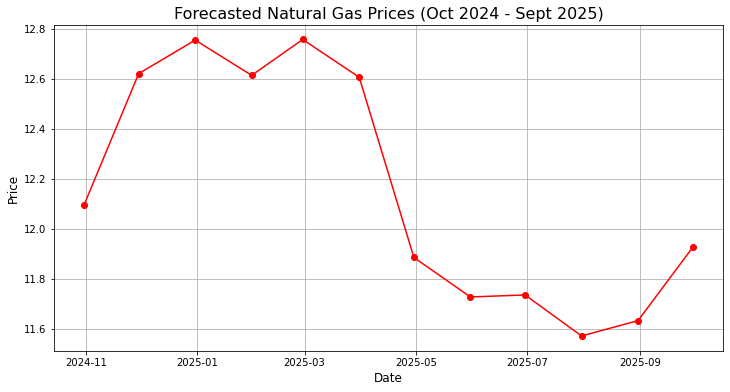

In [271]:
# Plot forecasted future prices
future_prices = forecast_prices()
future_dates = pd.date_range(start='2024-10-31', periods=12, freq='M')
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_prices, marker='o', linestyle='-', color='r')
plt.title('Forecasted Natural Gas Prices (Oct 2024 - Sept 2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.show()

### Plot for original dataset with forecasted prices (October 2020-Sept 2025)

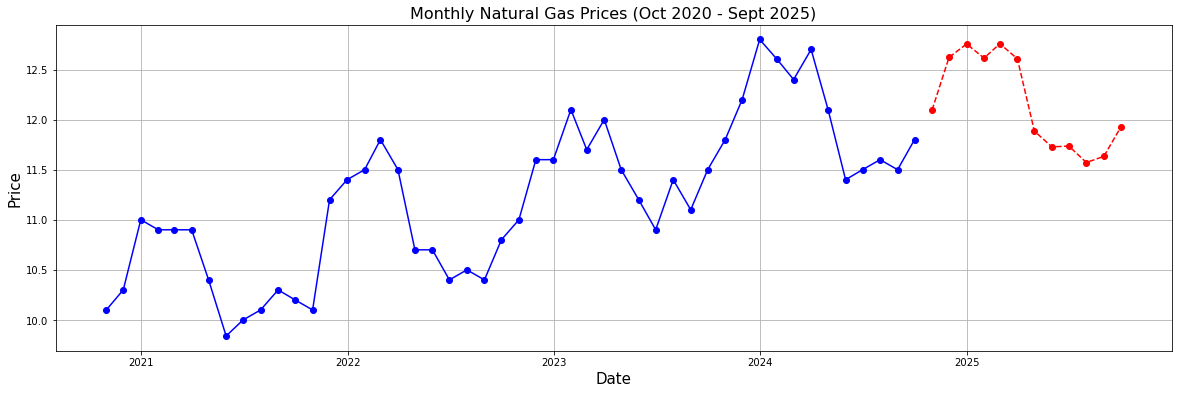

In [272]:
plt.figure(figsize=(20, 6))
plt.plot(df.index, df['Prices'], marker='o', color='b', linestyle='-')
plt.plot(future_dates, future_prices, marker='o', color='r', linestyle='--')
plt.title('Monthly Natural Gas Prices (Oct 2020 - Sept 2025)', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.grid(True)
plt.show()

In [273]:
df.head()

,Prices,Month,Quarter
Dates,,,
2020-10-31,10.1,10,4
2020-11-30,10.3,11,4
2020-12-31,11.0,12,4
2021-01-31,10.9,1,1
2021-02-28,10.9,2,1


### Function for estimating prices

In [274]:
# Price estimation function
def estimate_price(input_date):
    #converting dates to integers
    df=pd.read_csv("Nat_Gas.csv")
    df['Dates'] = pd.to_datetime(df['Dates'])
    df.set_index('Dates', inplace=True)
    input_numeric_date = pd.Timestamp(input_date).toordinal()
    numeric_dates = df.index.map(pd.Timestamp.toordinal)
    
     # Converting dates to numerical format (ordinal values)
    numeric_dates = df.index.map(pd.Timestamp.toordinal)

    # Creating the interpolation function and fill_value- extrapolate in order to estimate values outside given range
    interpolating_function = interp1d(numeric_dates, df['Prices'], kind='linear', fill_value="extrapolate")

    # Converting the input date to numeric format and estimate the price
    input_numeric_date = pd.Timestamp(input_date).toordinal()
    estimated_price = interpolating_function(input_numeric_date)
    return estimated_price
    


# Trial usage of function
input_date = '2020-11-28'
estimated_price = estimate_price(input_date)


print(f"Estimated price on {input_date}: {estimated_price: .2f}")

Estimated price on 2020-11-28:  10.29


### Conclusion

1. The estimates ofcourse are with the assumption that no other factors are changing during the time 